In [13]:
from glob import glob
import numpy as np
import cooler
from cooltools.sample import sample_cooler
from tqdm.notebook import tqdm
from os.path import basename

from matplotlib import pyplot as plt

In [19]:
#load data
PATHS = sorted(glob('./data/*.cool'))
NAMES = [basename(p).split('_')[0] for p in PATHS]
PATHS, NAMES

(['./data/0A_2000_down.cool',
  './data/0B_2000_down.cool',
  './data/2A_2000_down.cool',
  './data/2B_2000_down.cool',
  './data/5A_2000_down.cool',
  './data/5B_2000_down.cool',
  './data/8A_2000_down.cool',
  './data/8B_2000_down.cool'],
 ['0A', '0B', '2A', '2B', '5A', '5B', '8A', '8B'])

# Load Hi-C

In [20]:
#downsampling procedure
# RESOLUTION = 2000

# Clrs = [cooler.Cooler(p + "::/resolutions/%d" % RESOLUTION) for p in PATHS]
# MIN_SUM = min([c.info['sum'] for c in Clrs])
# for n, c in zip(NAMES, Clrs):
#     sample_cooler(c, './data/%s_%s_down.cool' % (n, RESOLUTION), 
#                   count=MIN_SUM//1000*1000)

In [21]:
Clrs = [cooler.Cooler(p) for p in PATHS]

<BarContainer object of 8 artists>

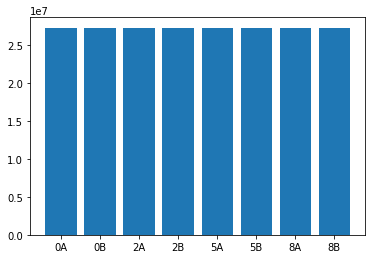

In [22]:
plt.bar(NAMES, [c.info['sum'] for c in Clrs])

## Preprocessing Hi-C

In [233]:
import numpy as np
from numba import njit
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm
import pandas as pd
import scipy
import scipy.signal
from collections import OrderedDict
import cooler
import bioframe
import cooltools
from astropy.convolution import Gaussian2DKernel
from cooltools.lib.numutils import adaptive_coarsegrain, interp_nan
import collections
import pyranges as pr
import pickle

import os
import sys

### ----- FUNCTIONS -------
def seq_df(df, fasta_records, mapped_only=True, return_input=True, thr=1):
    """
    Parameters
    ----------
    df : pandas.DataFrame
        A sets of genomic intervals stored as a DataFrame.
    fasta_records : OrderedDict
        Dictionary of chromosome names to sequence records.
        Created by: bioframe.load_fasta('/path/to/fasta.fa')
    mapped_only: bool
        if True, ignore 'N' in the fasta_records for calculation.
        if True and there are no mapped base-pairs in an interval, return np.nan.
    return_input: bool
        if False, only return Series named frac_mapped.
    Returns
    -------
    df_mapped : pd.DataFrame
        Original dataframe with new column 'frac_mapped' appended.
    """
    if not set(df["chrom"].values).issubset(set(fasta_records.keys())):
        return ValueError(
            "chrom from intervals not in fasta_records: double-check genome agreement"
        )
    if not type(fasta_records) is collections.OrderedDict:
        return ValueError(
            "fasta records must be provided as an OrderedDict, can be created by bioframe.load_fasta"
        )
    
    def _each(chrom_group):
        chrom = chrom_group.name
        seq = fasta_records[chrom]
        seq = str(seq[:])
        gc = []
        for _, bin in chrom_group.iterrows():
            s = seq[bin.start : bin.end].upper()
            n = 0
            if mapped_only:
                n = s.count("N")
            gc.append(s if n <= thr else 'nan')
        return gc

    out = df.groupby("chrom", sort=False).apply(_each)

    if return_input:
        return pd.concat(
            [df, pd.Series(data=np.concatenate(out), index=df.index).rename("SEQ")],
            axis="columns",
        )
    else:
        return pd.Series(data=np.concatenate(out), index=df.index).rename("SEQ")
    
def dnorm(x, mu, sd):
    return 1 / (np.sqrt(2 * np.pi) * sd) * np.e ** (-np.power((x - mu) / sd, 2) / 2)

def gaussian_kernel(size, sigma=1, verbose=False):
 
    kernel_1D = np.linspace(-(size // 2), size // 2, size)
    for i in range(size):
        kernel_1D[i] = dnorm(kernel_1D[i], 0, sigma)
    kernel_2D = np.outer(kernel_1D.T, kernel_1D.T)
 
    kernel_2D *= 1.0 / kernel_2D.max()
 
    if verbose:
        plt.imshow(kernel_2D, interpolation='none',cmap='gray')
        plt.title("Image")
        plt.show()
 
    return kernel_2D / kernel_2D.sum() #normalizer kernel to sum to 1

def make_expected_vals(cooler, Ndiags, chroms):
    vals = {}
    for chrom in tqdm(chroms): #remove the last chrY
        mat = cooler.matrix(balance=True, sparse=True).fetch(chrom)
        diags = scipy.sparse.triu(scipy.sparse.tril(mat, Ndiags), 0, 'dia')
        for i in range(Ndiags):
            if i not in vals:
                vals[i] = []
            arr = diags.data[i][diags.data[i]==diags.data[i]]
            vals[i].append([np.mean(arr), np.std(arr), arr.shape[0]]) #Std in case we want to do z-score
    avals = []
    for d in vals:
        l = np.sum([i[2] for i in vals[d]])
        m = np.array([i[0]*i[2] for i in vals[d]]).sum()/l
        s = np.array([i[1]*i[2] for i in vals[d]]).sum()/l
        avals.append((m ,s))
    return np.array(avals)

def hic_preprocess(A, E, mask, G_kernel=None, clip=[-2, 2]):
    """
    G_kernel:: 2d array: 
        200 pixels: (size=3, std=1.); 
        100 pixels: (size=3, std=0.6)
    """
    #---mask empty bins---
    A[mask, :] = np.nan
    A[:, mask] = np.nan
    #---OBS/EXP---
    E = scipy.linalg.toeplitz(E) #toeplitz expected matrix
    A_min = np.nanmin(A.ravel()[np.nonzero(A.ravel())])
    A_ = np.where(A==0., E, A) #np.where(A==0., A_min / 2, A) #fill zeros with (minimal nonzero / 2)
    #np.fill_diagonal(A_, np.nanmean(np.diag(A_, 0))) #fill diagonal of A with average main diagonal value
    R = np.array(np.log(A_ / E))
    R = cooltools.lib.numutils.interp_nan(R, method='linear') #linear interpolation
    
    if G_kernel is not None:
        #---SMOOTHING---
        R_ = scipy.signal.convolve2d(R, G_kernel, mode='same', boundary='fill')
        R_ = np.clip(R_, *clip)
        return R_
    else:
        R_ = np.clip(R, *clip)
        return R_
    

In [117]:
RESOLUTION_BINSIZE = 2000
N_PIXELS = 50
CHROMS = ['chr1', 'chr2', 'chr3', 'chr4', 'chr5', 'chr6']

In [85]:
EXP = [make_expected_vals(c, N_PIXELS, CHROMS)[:, 0] for c in Clrs]

In [145]:
cool_ = Clrs[0]
exp = EXP[0]

chrom = 'chr1'
start = 200_000
end = 300_000

B = cool_.bins().fetch('%s:%d-%d' % (chrom, start, end))
binmask = np.argwhere(np.isnan(np.array(B['weight'])))
A = cool_.matrix(balance=True, sparse=True).fetch('%s:%d-%d' % (chrom, start, end)).todense()
#non-balanced
U = cool_.matrix(balance=False, sparse=True).fetch('%s:%d-%d' % (chrom, start, end)).todense()

In [146]:
#coarse grained variant
cg = adaptive_coarsegrain(A, U, cutoff=2, max_levels=8)
R = hic_preprocess(cg, exp, binmask, G_kernel=Gaussian2DKernel(1.0), clip=[-2.0, 2.0])

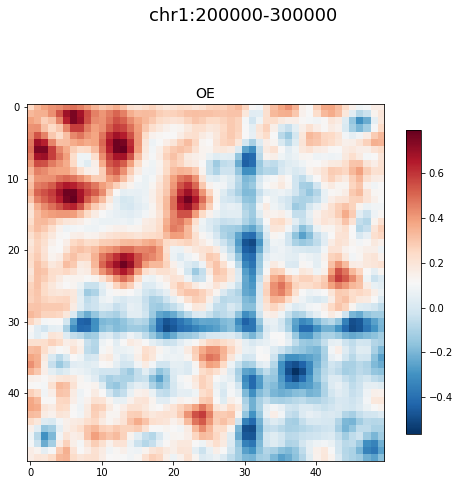

In [147]:
fig, ax = plt.subplots(1, 1, figsize=(8, 8))
fig.suptitle('%s:%d-%d' % (chrom, start, end), fontsize=18)
M1 = ax.imshow(R, cmap='RdBu_r', interpolation='none',) #vmin=-2.0, vmax=2.0)
#M2 = ax[1].imshow(R_low, cmap='RdBu_r', interpolation='none', vmin=-2.0, vmax=2.0)
ax.set_title('OE', fontsize=14)
#ax[1].set_title('Low resolution', fontsize=14)
plt.colorbar(M1, ax=ax, shrink=0.7)
#plt.colorbar(M2, ax=ax[1], shrink=0.7)
plt.show()

## Preprocessing DNA

In [343]:
#from https://www.ncbi.nlm.nih.gov/genome/?term=dictyostelium+discoideum

dicty = bioframe.load_fasta('./genome/GCF_000004695.1_dicty_2.7_genomic.fna')
dicty_stat = pd.read_csv('./genome/GCF_000004695.1_dicty_2.7_genomic.fna.fai', sep='\t', header=None)
dicty_report = pd.read_csv('./genome/GCF_000004695.1_dicty_2.7_assembly_report.txt', sep='\t', skiprows=29)

In [344]:
chromsizes = Clrs[0].chromsizes.iloc[:6]
chrom_seq_dict = OrderedDict({n:v for v,n in zip(list(dicty.values())[:6],
                                                 list(chromsizes.keys())[:6])})
chromosomes = list(chrom_seq_dict.keys())

In [345]:
bins = cooler.binnify(chromsizes, RESOLUTION_BINSIZE)
seqdf = seq_df(bins, chrom_seq_dict, mapped_only=True, return_input=True, thr=20)
#seqdf = seqdf[seqdf['SEQ'] != 'NAN'] #drop nan

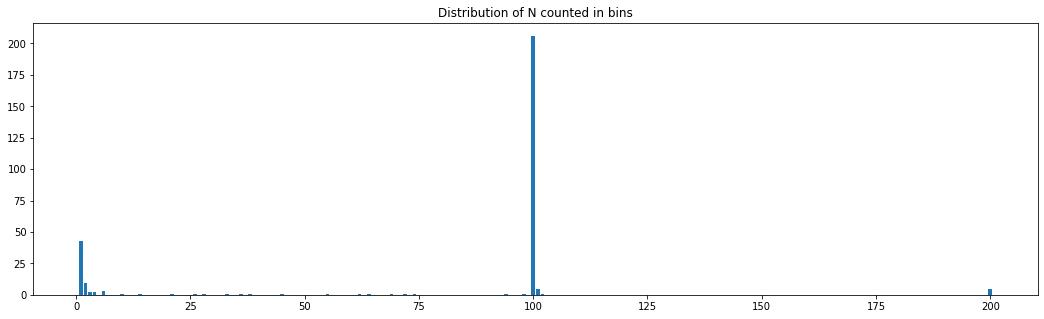

In [329]:
# a, b = np.unique(seqdf.SEQ.apply(str.count, args=('N')), return_counts=True)

# plt.figure(figsize=(18,5))
# plt.bar(a[1:], b[1:])
# plt.title('Distribution of N counted in bins')
# plt.show()

In [346]:
print('N symbols saved in total %d' % seqdf.SEQ.apply(str.count, args=('N')).sum()) #count all `N`
print('NANs: %d' % seqdf[seqdf['SEQ'] == 'nan'].shape[0])

N symbols saved in total 117
NANs: 232


<AxesSubplot:>

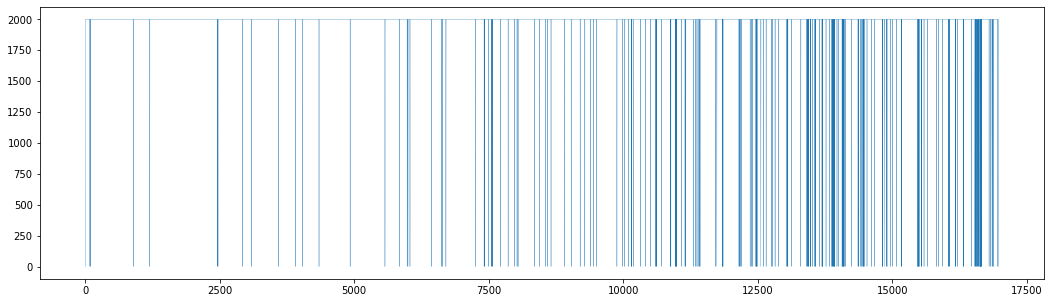

In [347]:
plt.figure(figsize=(18,5))
seqdf.SEQ.apply(len).plot(lw=0.3)

## Compilation

In [368]:
coord_list = []
hic_list = []
seq_list = []
gkernel = Gaussian2DKernel(1.0)

bin_gaps = 0
inc_seq = 0
nan_maps = 0

for cool_, exp_ in zip(Clrs, EXP):
    print('Process %s' % cool_.filename)
    for chrom in tqdm(chromosomes):
        seqdf_chrom = seqdf[seqdf['chrom']==chrom]
        n = len(seqdf_chrom) // N_PIXELS
        if n == 0:
            continue
        else:
            for j in tqdm(range(n), leave=False):
                sub = seqdf_chrom.iloc[j * N_PIXELS: (j + 1) * N_PIXELS]
                start, end = sub.iloc[0]['start'], sub.iloc[-1]['end']
                if end - start != RESOLUTION_BINSIZE * N_PIXELS:
                    bin_gaps += 1
                    continue

                sequence = ''.join(sub['SEQ'].tolist())
                if len(sequence) != RESOLUTION_BINSIZE * N_PIXELS:
                    inc_seq += 1
                    #print('Incorrect sequence length')
                    continue

                #---FETCHING---
                B = cool_.bins().fetch('%s:%d-%d' % (chrom, start, end))
                binmask = np.argwhere(np.isnan(np.array(B['weight'])))
                #balanced
                A = cool_.matrix(balance=True, sparse=True).\
                        fetch('%s:%d-%d' % (chrom, start, end)).todense()
                #non-balanced
                U = cool_.matrix(balance=False, sparse=True).fetch('%s:%d-%d' % (chrom, start, end)).todense()

                assert A.shape[0] == N_PIXELS, 'Wrong shape fetched'
                assert U.shape[0] == N_PIXELS, 'Wrong shape fetched'


                #---PREPROCESSING---
                #coarse grained variant
                cg = adaptive_coarsegrain(A, U, cutoff=2, max_levels=8)

                #O/E matrices
                R = hic_preprocess(cg, exp_, binmask, G_kernel=gkernel)

                if (np.isnan(R).any()) or (R.sum()==0.):
                    nan_maps += 1
                    continue

                #---GATHERING---
                coord_list.append((chrom, start, end))
                hic_list.append(R)
                seq_list.append(sequence)
            
print('Done:')
print('Hi-C maps generated: %d' % len(hic_list))
print('Total bin gaps: %d' % bin_gaps)
print('Total incorrect sequences: %d' % inc_seq)
print('Total NaN maps found: %d' % nan_maps)

Process ./data/0A_2000_down.cool


/home/d.kriukov/.local/lib/python3.7/site-packages/cooltools/lib/numutils.py:1355: RuntimeWarning: invalid value encountered in true_divide
  val_cur = ar_cur / armask_cur


/opt/Anaconda/2020/lib/python3.7/site-packages/ipykernel_launcher.py:122: RuntimeWarning: All-NaN slice encountered



Process ./data/0B_2000_down.cool



Process ./data/2A_2000_down.cool



Process ./data/2B_2000_down.cool



Process ./data/5A_2000_down.cool



Process ./data/5B_2000_down.cool



Process ./data/8A_2000_down.cool



Process ./data/8B_2000_down.cool



Done:
Hi-C maps generated: 1634
Total bin gaps: 0
Total incorrect sequences: 968
Total NaN maps found: 94


In [369]:
hi_stack = np.stack(hic_list).astype(np.float32)

In [371]:
#save sequences
with open('./dataset/sequences.txt', 'wb') as f:
    pickle.dump(seq_list, f)
    
#save coords
with open('./dataset/coords.txt', 'wb') as f:
    pickle.dump(coord_list, f)
    
#save maps
np.save('./dataset/tensor.npy', hi_stack)

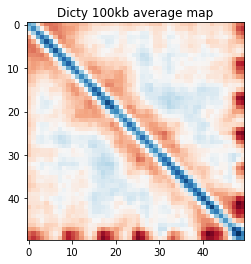

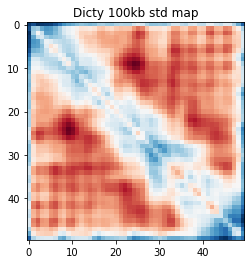

In [391]:
plt.imshow(np.median(hi_stack, 0), cmap='RdBu_r', interpolation='none')
plt.title('Dicty 100kb average map')
plt.show()

plt.imshow(hi_stack.std(0), cmap='RdBu_r', interpolation='none')
plt.title('Dicty 100kb std map')
plt.show()

### Vizualization

In [356]:
np.argwhere(np.array([h.sum() for h in hic_list]) == 0)

array([[64],
       [65],
       [66],
       [67],
       [68],
       [69],
       [70],
       [71],
       [72],
       [73],
       [74],
       [75]])

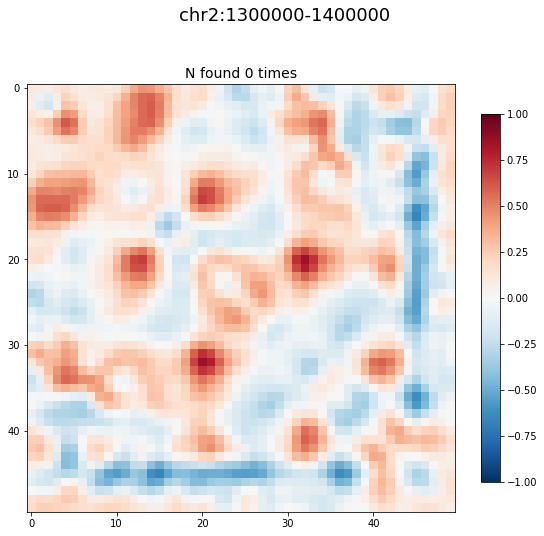

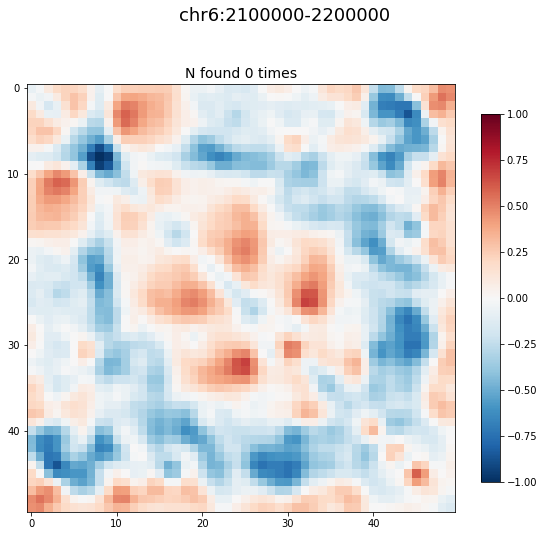

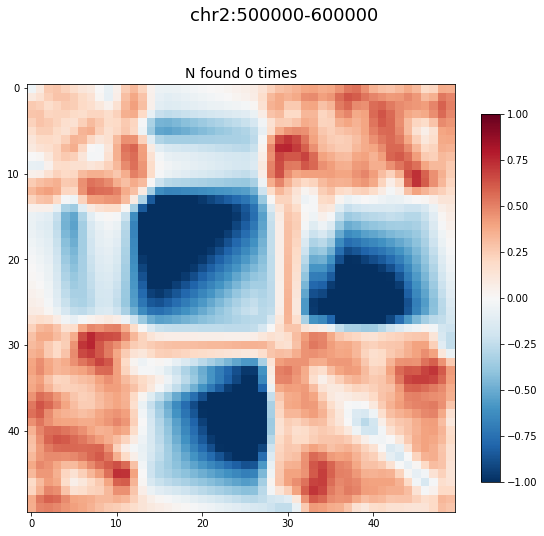

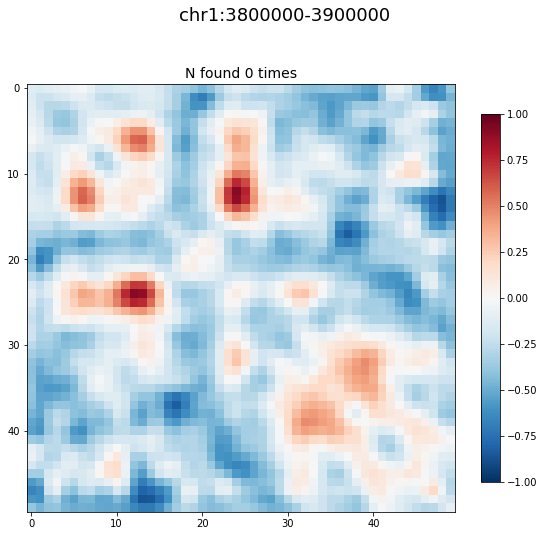

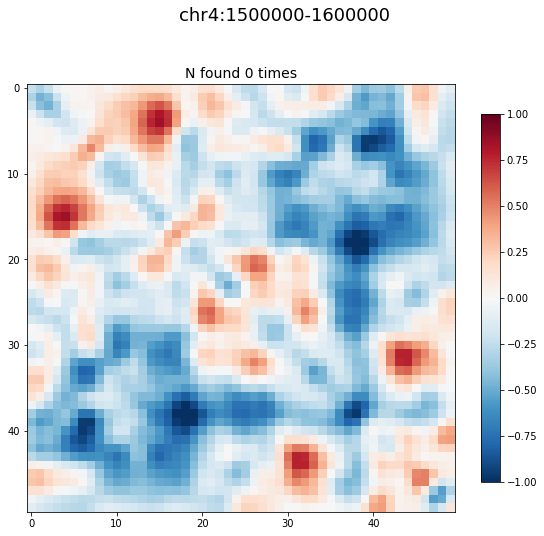

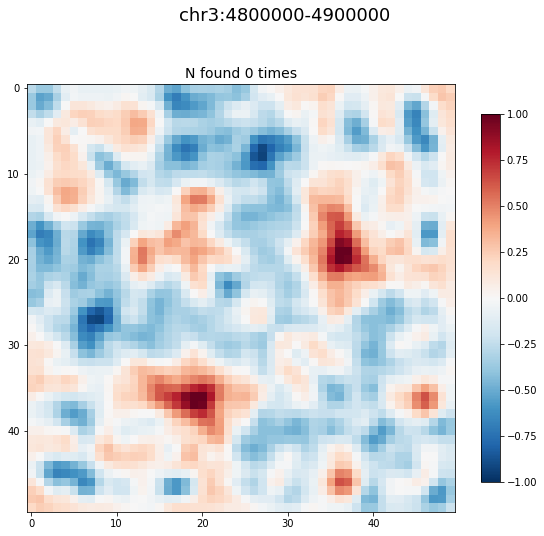

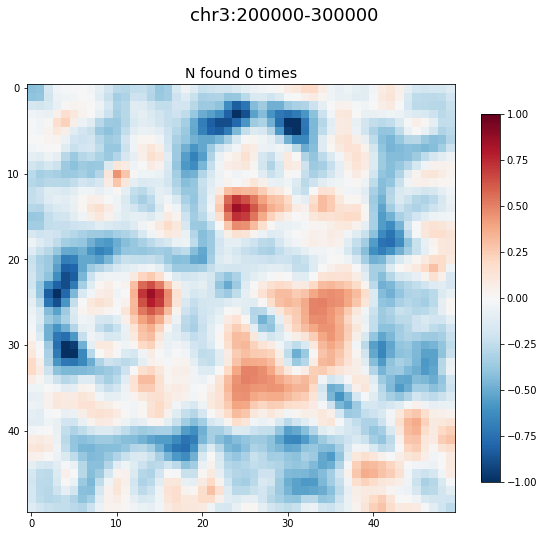

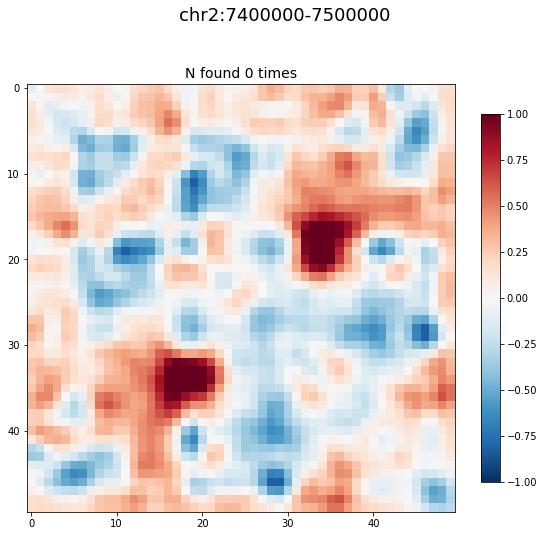

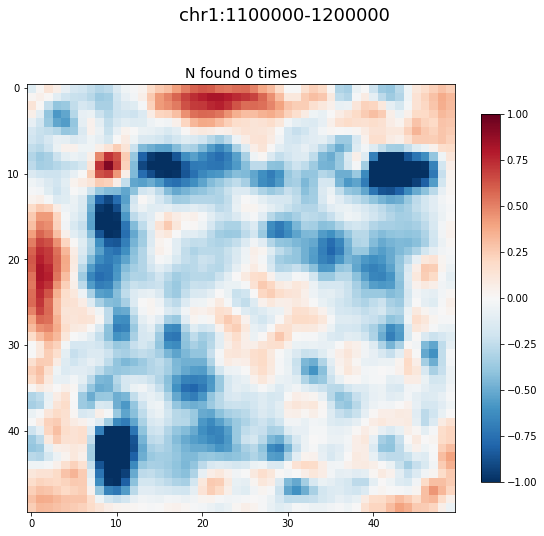

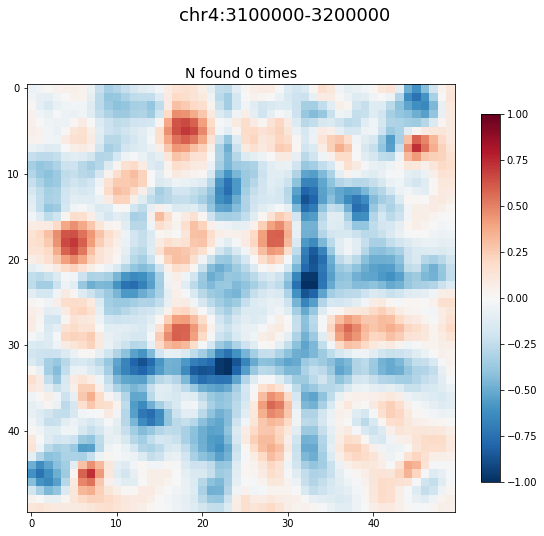

In [393]:
N = 10
ids = np.random.randint(0, len(seq_list), N)
for i in ids:
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    fig.suptitle('%s:%d-%d' % coord_list[i], fontsize=18)
    M1 = ax.imshow(hic_list[i], cmap='RdBu_r', interpolation='none', 
                      vmin=-1.0, vmax=1.0)
    NN = seq_list[i].count('N')
    ax.set_title('N found %d times' % NN, fontsize=14)
    plt.colorbar(M1, ax=ax, shrink=0.7)
    plt.tight_layout()
    plt.show()
    